In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import os


from sklearn.metrics import silhouette_score

from sklearn.utils.extmath import cartesian
from sklearn.cluster import KMeans, MiniBatchKMeans

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText


import descartes
import geopandas as gpd
from geopandas import GeoSeries

from shapely.geometry import Point, Polygon

from convertbng.util import convert_bng, convert_to_etrs89

import gif

%matplotlib inline

In [2]:
road_map = gpd.read_file("../capstone_train/police_map/GBR_roads.shp")
df = pd.read_csv("../capstone_train/train.csv")

In [3]:
def pre_process(df):
    df = df.copy()
    
    # remove data from Metropolitan station
    df = df[~(df['station'] == 'metropolitan')]
    
    # ex: '2019-12-01T00:36:39.650000+'
    df['Date'] = df['Date'].str[:19]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S')
    df['hour'] = df['Date'].dt.hour
    df['month'] = df['Date'].dt.month
    df['day_of_week'] = df['Date'].dt.day_name()
    
    df = df.set_index('Date').sort_index()
    
    # drop columns
    columns_to_drop = ['Self-defined ethnicity', 'observation_id']
    df = df.drop(columns=columns_to_drop)
    
    # fill NaN's:
    # 1) 'Removal of more than just outer clothing' = False if not a 'Vehicle search'
    # 2) 'Part of a policing operation' = False
    df.loc[(df['Type'].isin(['Vehicle search'])), 'Removal of more than just outer clothing'] = np.NaN
    df.loc[(pd.isnull(df['Removal of more than just outer clothing']) & df['Type'].isin(['Person and Vehicle search', 'Person search'])), 'Removal of more than just outer clothing'] = False
    df.loc[(pd.isnull(df['Part of a policing operation'])), 'Part of a policing operation'] = False

    # build target: positive outcomes + Outcome linked to object of search
    def build_target(df):
        positive_outcomes = ['Local resolution', 'Community resolution', 'Offender given drugs possession warning','Khat or Cannabis warning', 'Caution (simple or conditional)', 'Offender given penalty notice', 'Arrest', 'Penalty Notice for Disorder','Suspected psychoactive substances seized - No further action', 'Summons / charged by post', 'Article found - Detailed outcome unavailable', 'Offender cautioned', 'Suspect arrested','Suspect summonsed to court']
        if df['Outcome'] in positive_outcomes and df['Outcome linked to object of search'] == True:
            return 1
        else:
            return 0
    df['target'] = df.apply(build_target, axis=1)
    
    return df

df_clean = pre_process(df)
df_clean

,Type,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,hour,month,day_of_week,target
Date,,,,,,,,,,,,,,,,,
2017-12-01 00:00:00,Person and Vehicle search,False,50.918350,0.477208,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,True,False,sussex,0,12,Friday,1
2017-12-01 00:00:00,Person search,False,NaN,NaN,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Anything to threaten or harm anyone,Nothing found - no further action,NaN,True,dyfed-powys,0,12,Friday,0
2017-12-01 00:00:00,Person search,False,50.833027,-0.423851,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,True,False,sussex,0,12,Friday,0
2017-12-01 00:00:00,Person search,False,51.104265,-0.210224,Male,10-17,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,True,False,sussex,0,12,Friday,0
2017-12-01 00:00:00,Person and Vehicle search,False,50.918350,0.477208,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,True,False,sussex,0,12,Friday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:50:00,Person search,False,51.744048,-0.032926,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,hertfordshire,23,12,Tuesday,0
2019-12-31 23:50:00,Person and Vehicle search,False,51.434985,0.166419,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Psychoactive substances,Summons / charged by post,False,False,kent,23,12,Tuesday,0
2019-12-31 23:53:00,Person search,False,NaN,NaN,Male,18-24,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,south-yorkshire,23,12,Tuesday,0


In [4]:
geometry = [Point(xy) for xy in zip(df_clean["Longitude"], df_clean["Latitude"])]
df_geo = gpd.GeoDataFrame(df_clean, crs = road_map.crs, geometry = geometry)
df_geo = df_geo.dropna(subset=['Latitude', 'Longitude'])

In [18]:
rows_list = []

df_ready = df_geo.copy()
for station in df_ready.station.unique():
    df_station = df_ready[df_ready['station'] == station]

    dates = [2018, 2019]
    for date in dates:

        df_time = df_station[df_station.index.year==date]
        
        if df_time.empty:
            print(f'{station} for period {date_ini}:{date_fin} don\'t have observations')
            continue
            
        date_ini = df_time.index[0].strftime('%B %Y')
        date_fin = df_time.index[-1].strftime('%B %Y')

        condition_white = df_time['Officer-defined ethnicity'] == 'White'
        condition_black = df_time['Officer-defined ethnicity'] == 'Black'
        
        condition_success = df_time['target'] == 1
        condition_fail = df_time['target'] == 0

        white_fail = df_time[condition_fail & condition_white]
        white_success = df_time[condition_success & condition_white]
        back_fail = df_time[condition_fail & condition_black]
        black_win = df_time[condition_success & condition_black]

        station_spaced = station.replace('-',' ')
        capitalized_parts = station_spaced.split(" ")
        capitalized_parts[0] = capitalized_parts[0].capitalize()
        capitalized_parts[-1] = capitalized_parts[-1].capitalize()
        station_name_clean = " ".join(capitalized_parts)

        success_rate = round(df_time['target'].mean()*100, 2)
        success_black = round(df_time.loc[(condition_black), 'target'].mean()*100, 2)
        success_white = round(df_time.loc[(condition_white), 'target'].mean()*100, 2)
        sucess_discrepancy = round(success_black - success_white, 2)
        
        dic_to_df_gender = {'station': station, 'year': date, 'white success': success_white, 'black success': success_black,'success discrepancy': sucess_discrepancy }
        rows_list.append(dic_to_df_gender)

devon-and-cornwall for period January 2019:December 2019 don't have observations
dyfed-powys for period March 2019:December 2019 don't have observations


In [13]:
df2 = pd.DataFrame(rows_list)
df2.head()

,station,year,white success,black success,success discrepancy
0,sussex,2018,23.06,24.41,1.35
1,sussex,2019,15.46,14.36,-1.10
2,north-yorkshire,2018,17.27,22.73,5.46
3,north-yorkshire,2019,14.51,14.71,0.20
4,hampshire,2018,17.20,26.63,9.43


In [10]:
top_n = 10
difff = abs(df2['success discrepancy'].diff())
idexx = difff[1::2].sort_values(ascending=False).index[:top_n]
dif_to_plot = difff[1::2].sort_values(ascending=False)[:top_n]
order = df2.loc[idexx]['station'].values
top_10_diff = df2[df2.station.isin(df2.loc[idexx]['station'])]

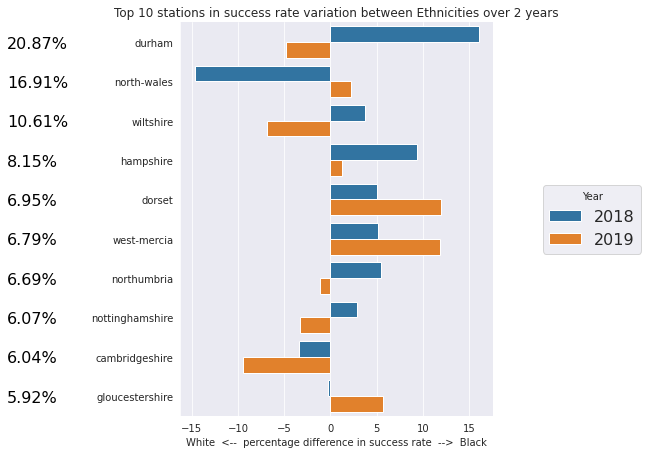

In [11]:
sns.set_style("darkgrid")

g = sns.catplot(data=top_10_diff, kind="bar", x="success discrepancy", y="station", 
                hue="year", orient="h", height=6, order = order, dodge=True).set(title='Top 10 stations in success rate variation between Ethnicities over 2 years')
g.set(xlabel="White  <--  percentage difference in success rate  -->  Black", ylabel = "" )
g._legend.remove()
ax = g.facet_axis(0,0)
ax.legend(title = 'Year', prop=dict(size=16), loc="right", bbox_to_anchor = (1.5,0.5))

for i ,p in enumerate(ax.patches):
    if i<top_n:
        percent = round(dif_to_plot.iloc[i], 2)
        ax.text(p.get_x() -35, p.get_y()+0.55, f"{percent:.2f}%",  color='black', rotation='horizontal', size=16)

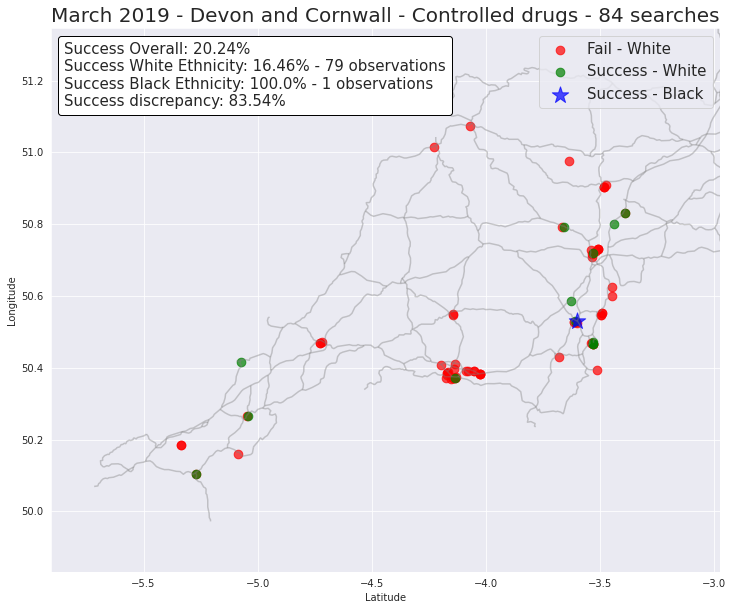

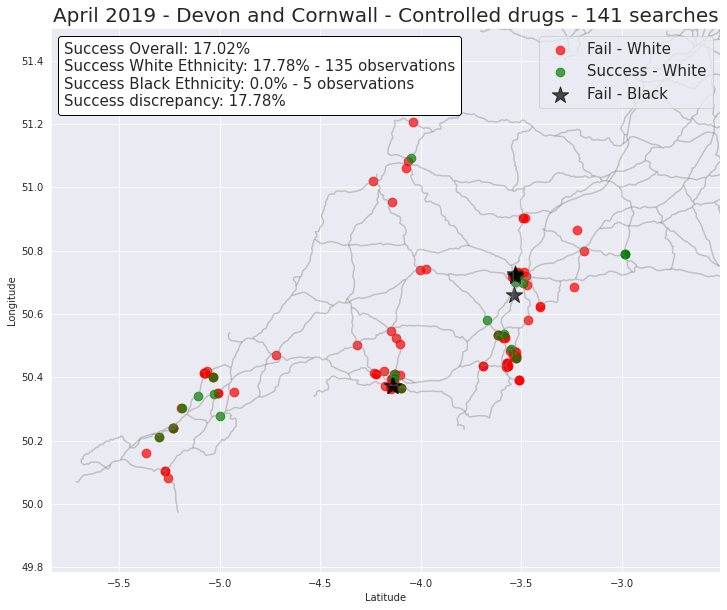

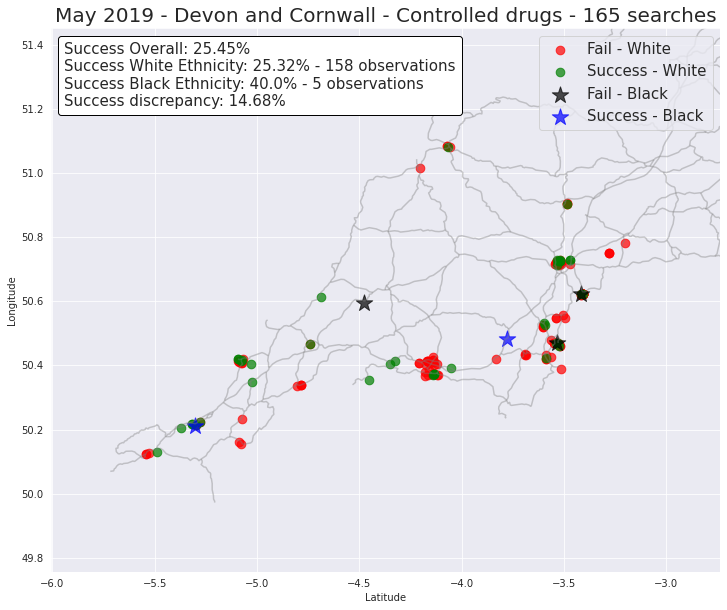

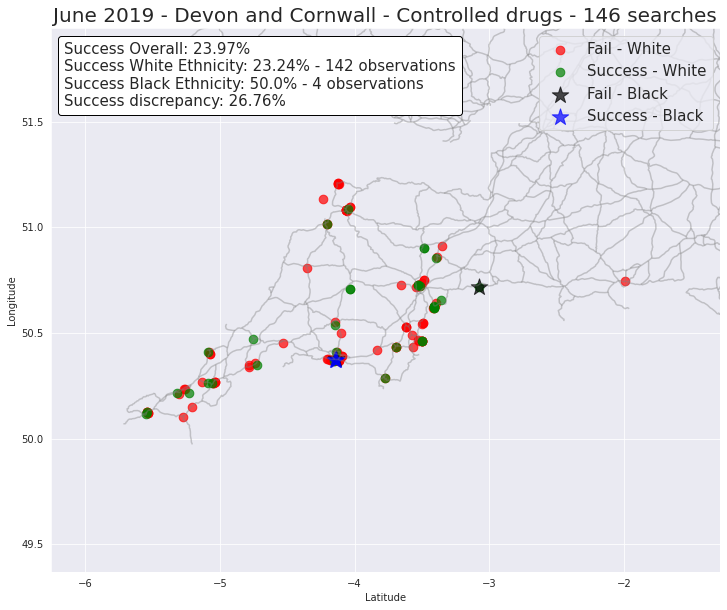

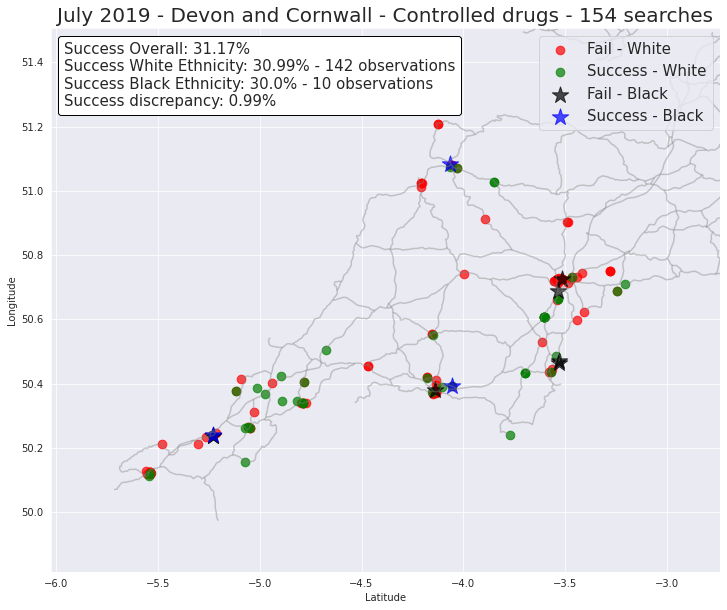

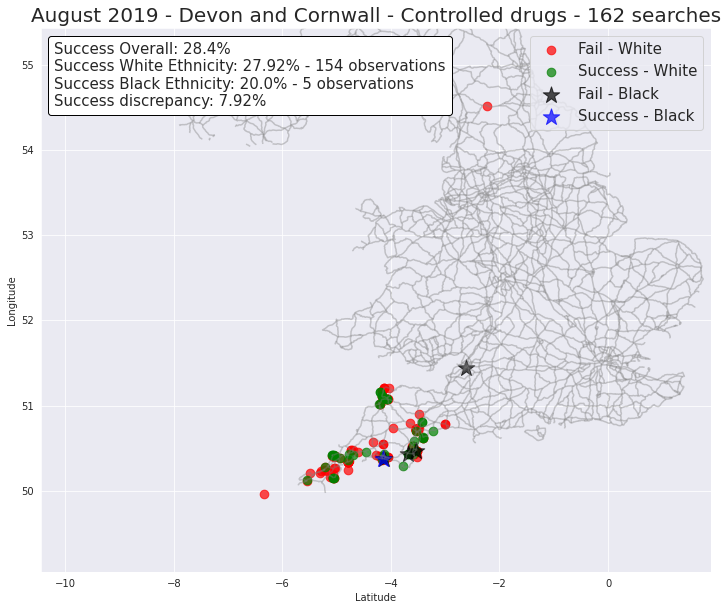

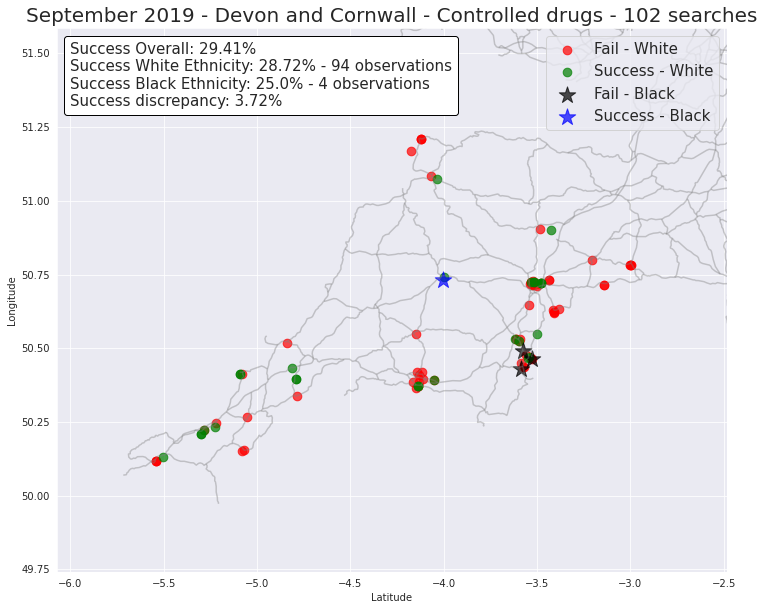

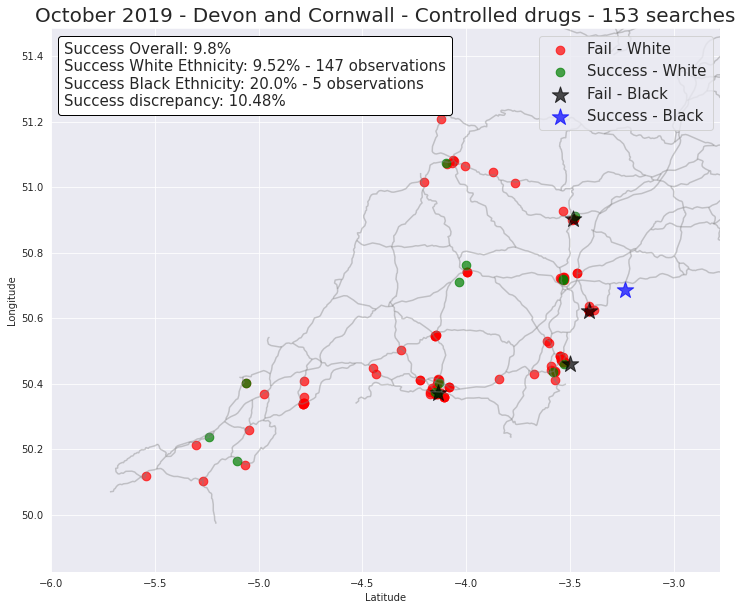

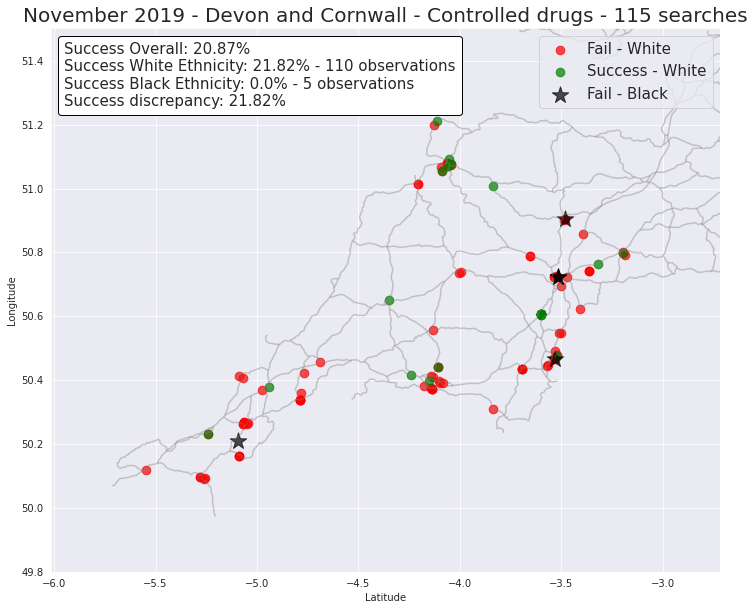

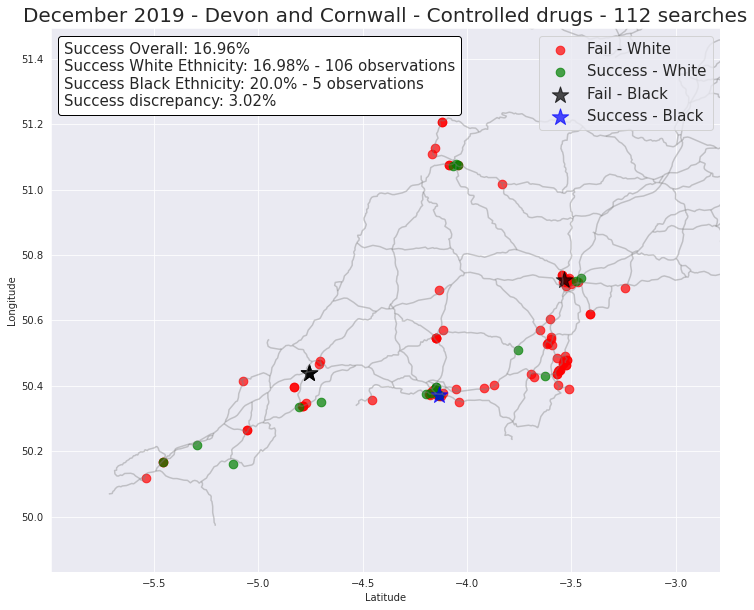

In [15]:
station_list = ['devon-and-cornwall']
obj_list =  ['Controlled drugs'] #df_geo['Object of search'].unique()

df_ready = df_geo.copy()
for station in station_list:
    df_station = df_ready[df_ready['station'] == station]

    for obj in obj_list:
        df_obj = df_station[df_station['Object of search'] == obj]
        
        previous_date = df_obj.index[0]
        for date in pd.date_range(start = df_obj.index[0], end = df_obj.index[-1], freq = '1M'):
            
            df_time = df_obj[previous_date:pd.Timestamp(date)]

            date_ini = previous_date.strftime('%B %Y')
            date_fin = df_time.index[-1].strftime('%B %Y')
            previous_date = df_time.index[-1]

            if df_time.empty:
                print(f'{station} and {obj} for period {date_ini}:{date_fin} don\'t have observations')
                continue

            fig, ax = plt.subplots(figsize = (12, 10))
            ax.set_aspect(1, "datalim")

            road_map.plot(ax = ax, alpha = 0.4, color = "grey")
            
            condition_white = df_time['Officer-defined ethnicity'] == 'White'
            condition_black = df_time['Officer-defined ethnicity'] == 'Black'
            condition_success = df_time['target'] == 1
            condition_fail = df_time['target'] == 0
            
            white_fail = df_time[condition_fail & condition_white]
            if not white_fail.empty:
                white_fail.plot(ax = ax, markersize = 300, alpha = 0.7, color = "red", marker = '.',  label = 'Fail - White')
            
            white_success = df_time[condition_success & condition_white]
            if not white_success.empty:
                white_success.plot(ax = ax, markersize = 300, alpha = 0.7, color = "green", marker = '.', label = 'Success - White')
            
            back_fail = df_time[condition_fail & condition_black]
            if not back_fail.empty:
                back_fail.plot(ax = ax, markersize = 300, alpha = 0.7, color = "black", marker = '*',  label = 'Fail - Black')
            
            black_win = df_time[condition_success & condition_black]
            if not black_win.empty:
                black_win.plot(ax = ax, markersize = 300, alpha = 0.7, color = "blue", marker = '*', label = 'Success - Black')

            x_min = df_time['Longitude'].min()
            x_max = df_time['Longitude'].max()  
            y_min = df_time['Latitude'].min()
            y_max = df_time['Latitude'].max()
            margin_x = (x_max-x_min)/5
            margin_y = (y_max-y_min)/5

            station_spaced = station.replace('-',' ')
            capitalized_parts = station_spaced.split(" ")
            capitalized_parts[0] = capitalized_parts[0].capitalize()
            capitalized_parts[-1] = capitalized_parts[-1].capitalize()
            station_name_clean = " ".join(capitalized_parts)
            
            success_rate = round(df_time['target'].mean()*100, 2)
            success_black = round(df_time.loc[(condition_black), 'target'].mean()*100, 2)
            success_white = round(df_time.loc[(condition_white), 'target'].mean()*100, 2)
            sucess_discrepancy = round(abs(success_black - success_white), 2)
            
            at = AnchoredText(f"Success Overall: {success_rate}%\n"\
                                f"Success White Ethnicity: {success_white}% - {df_time.loc[condition_white].shape[0]} observations\n"\
                                f"Success Black Ethnicity: {success_black}% - {df_time.loc[condition_black].shape[0]} observations\n"\
                                f"Success discrepancy: {sucess_discrepancy}%" , prop=dict(size=15), frameon=True, loc='upper left')
            at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax.add_artist(at)

            plt.axis([x_min-margin_x, x_max+margin_x, y_min-margin_y, y_max+margin_y])
            plt.legend(prop = {'size': 15})
            plt.title(f'{date_fin} - {station_name_clean} - {obj} - {df_time.shape[0]} searches',fontsize= 20)
            plt.xlabel('Latitude')
            plt.ylabel('Longitude')
            plt.show()

<ipython-input-16-a0b6d3b3f0ea>:75: UserWarning: Attempting to set identical left == right == -1.317631 results in singular transformations; automatically expanding.
  plt.axis([x_min-margin_x, x_max+margin_x, y_min-margin_y, y_max+margin_y])
<ipython-input-16-a0b6d3b3f0ea>:75: UserWarning: Attempting to set identical bottom == top == 54.762977 results in singular transformations; automatically expanding.
  plt.axis([x_min-margin_x, x_max+margin_x, y_min-margin_y, y_max+margin_y])


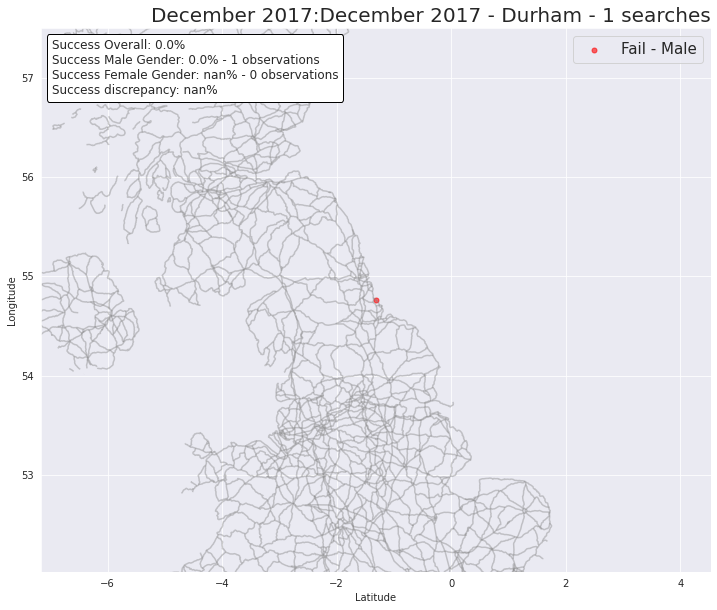

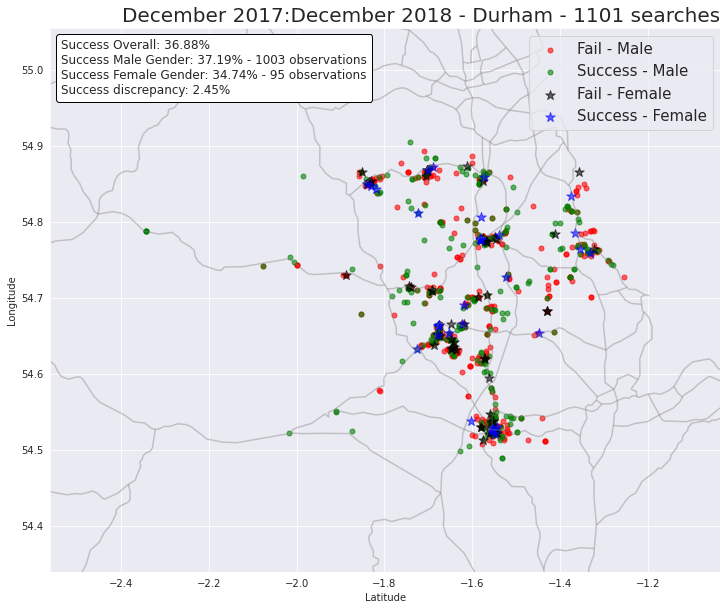

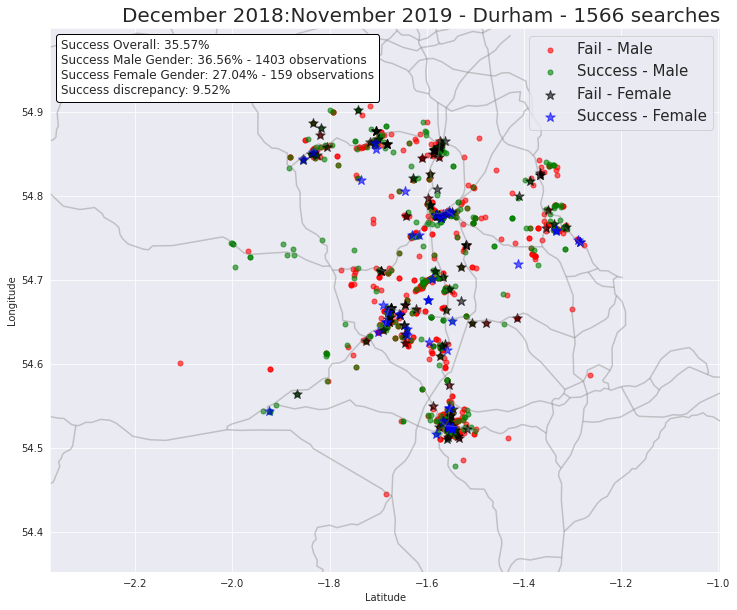

In [16]:
station_list = ['durham']
obj_list =  ['Controlled drugs'] #df_geo['Object of search'].unique()

df_ready = df_geo.copy()
for station in station_list:
    df_station = df_ready[df_ready['station'] == station]

    previous_date = df_station.index[0]
    for date in pd.date_range(start = df_station.index[0], periods=3, freq=pd.DateOffset(years=1)):

        df_time = df_station[previous_date:pd.Timestamp(date)]

        date_ini = previous_date.strftime('%B %Y')
        date_fin = df_time.index[-1].strftime('%B %Y')
        previous_date = df_time.index[-1]

        if df_time.empty:
            print(f'{station} for period {date_ini}:{date_fin} don\'t have observations')
            continue

        fig, ax = plt.subplots(figsize = (12, 10))
        ax.set_aspect(1, "datalim")

        road_map.plot(ax = ax, alpha = 0.4, color = "grey")
        
        condition_male = df_time['Gender'] == 'Male'
        condition_female = df_time['Gender'] == 'Female'
        
        condition_success = df_time['target'] == 1
        condition_fail = df_time['target'] == 0

        white_fail = df_time[condition_fail & condition_male]
        if not white_fail.empty:
            white_fail.plot(ax = ax, markersize = 100, alpha = 0.6, color = "red", marker = '.',  label = 'Fail - Male')

        white_success = df_time[condition_success & condition_male]
        if not white_success.empty:
            white_success.plot(ax = ax, markersize = 100, alpha = 0.6, color = "green", marker = '.', label = 'Success - Male')

        back_fail = df_time[condition_fail & condition_female]
        if not back_fail.empty:
            back_fail.plot(ax = ax, markersize = 100, alpha = 0.6, color = "black", marker = '*',  label = 'Fail - Female')

        black_win = df_time[condition_success & condition_female]
        if not black_win.empty:
            black_win.plot(ax = ax, markersize = 100, alpha = 0.6, color = "blue", marker = '*', label = 'Success - Female')

        x_min = df_time['Longitude'].min()
        x_max = df_time['Longitude'].max()  
        y_min = df_time['Latitude'].min()
        y_max = df_time['Latitude'].max()
        margin_x = (x_max-x_min)/5
        margin_y = (y_max-y_min)/5

        station_spaced = station.replace('-',' ')
        capitalized_parts = station_spaced.split(" ")
        capitalized_parts[0] = capitalized_parts[0].capitalize()
        capitalized_parts[-1] = capitalized_parts[-1].capitalize()
        station_name_clean = " ".join(capitalized_parts)

        success_rate = round(df_time['target'].mean()*100, 2)
        success_female = round(df_time.loc[(condition_female), 'target'].mean()*100, 2)
        success_male = round(df_time.loc[(condition_male), 'target'].mean()*100, 2)
        sucess_discrepancy = round(abs(success_female - success_male), 2)

        at = AnchoredText(f"Success Overall: {success_rate}%\n"
                          f"Success Male Gender: {success_male}% - {df_time.loc[condition_male].shape[0]} observations\n"\
                            f"Success Female Gender: {success_female}% - {df_time.loc[condition_female].shape[0]} observations\n"\
                            f"Success discrepancy: {sucess_discrepancy}%",
                          loc='upper left', prop=dict(size=12), frameon=True,
                          )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)

        plt.axis([x_min-margin_x, x_max+margin_x, y_min-margin_y, y_max+margin_y])
        plt.legend(prop = {'size': 15})
        plt.title(f'{date_ini}:{date_fin} - {station_name_clean} - {df_time.shape[0]} searches',fontsize= 20, loc='right')
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.show()